In [21]:
import pandas as pd
from src.utils.timescaledb_ops import TimescaleDBOps

In [33]:
tsdb_ops = TimescaleDBOps()
# columns, data = tsdb_ops.read_data("silver.ohlc_daily")
# columns, data = tsdb_ops.read_data("silver.ohlc_weekly")
columns, data = tsdb_ops.read_data("silver.ohlc_monthly")
df = pd.DataFrame(data=data, columns=columns)
df = df.sort_values("date").reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])

2025-06-18 21:51:33,762 - INFO - Data read from silver.ohlc_monthly successfully.


In [34]:
df.head()

,date,pair,open,high,low,close,volume,count
0,2013-10-01,XXBTZUSD,122.00000,207.30246,122.00000,199.60000,2567.0,3157
1,2013-11-01,XXBTZUSD,199.50000,1198.80090,199.50000,1161.97234,8133.0,1291
2,2013-12-01,XXBTZUSD,1132.19324,1162.00000,380.00000,746.10148,15945.0,1440
3,2014-01-01,XXBTZUSD,738.00000,1019.00000,737.15115,812.63409,9887.0,900
4,2014-02-01,XXBTZUSD,801.24000,835.00000,450.00000,584.40106,10586.0,1035


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    141 non-null    datetime64[ns]
 1   pair    141 non-null    object        
 2   open    141 non-null    float64       
 3   high    141 non-null    float64       
 4   low     141 non-null    float64       
 5   close   141 non-null    float64       
 6   volume  141 non-null    float64       
 7   count   141 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 8.9+ KB


In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_ohlcv(df: pd.DataFrame, title: str = "OHLCV Chart"):
    """
    Plots OHLCV data using Plotly with candlestick and volume subplot.

    Parameters:
    - df (pd.DataFrame): DataFrame with ['date', 'open', 'high', 'low', 'close', 'volume']
    - title (str): Title for the chart
    """

    # Validate required columns
    required_cols = {'date', 'open', 'high', 'low', 'close', 'volume'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")

    # Ensure datetime is in correct format
    df['date'] = pd.to_datetime(df['date'])

    # Create subplot with 2 rows (OHLC and Volume)
    fig = make_subplots(rows=4, cols=1, 
                        shared_xaxes=True, 
                        vertical_spacing=0.02,
                        row_heights=[0.55, 0.15, 0.15, 0.15],
                        subplot_titles=(title, "Volume"))

    # Add candlestick
    fig.add_trace(go.Candlestick(
        x=df['date'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name="Price",
        increasing_line_color='green',
        decreasing_line_color='red'
    ), row=1, col=1)

    # Add volume bar chart
    fig.add_trace(go.Bar(
        x=df['date'],
        y=df['volume'],
        name="Volume",
        marker_color='orange'
    ), row=2, col=1)

    # Layout adjustments
    fig.update_layout(
        title=title,
        xaxis_rangeslider_visible=False,
        template='plotly_dark',
        height=700,
        margin=dict(l=50, r=25, t=50, b=40)
    )
    
    return fig

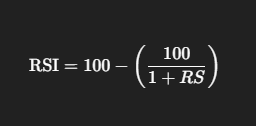

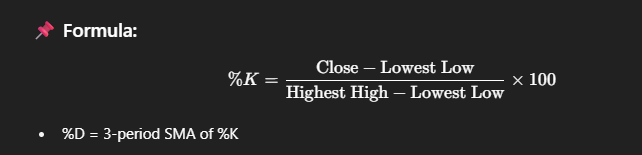

In [ ]:
# Technical Analysis
# EMA
df['ema_13'] = df['close'].ewm(span=13, adjust=False).mean()
df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()

# # RSI
# window = 14 # default setting
# delta = df['close'].diff(1)
# avg_gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # avg_gain 
# avg_loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
# rsi = avg_gain / avg_loss
# df['rsi'] = 100 - (100 / (1 + rsi)) 

# Stochastic
perc_k_length = 5
perc_k_smoothing = 3
perc_d_length = 3

lowest_low = df['low'].rolling(window).min()
highest_high = df['high'].rolling(window).max()
df["stochastic_%K"] = ((df['close'] -lowest_low) / (highest_high -lowest_low)).rolling(perc_k_smoothing).mean() 
df["stochastic_%D"] =  df["stochastic_%K"].rolling(perc_d_length).mean()

# MACD
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()

macd = ema_12 - ema_26
macd_signal_line = macd.ewm(span=9, adjust=False).mean()
macd_bar = macd - macd_signal_line

df['macd'] = macd
df['macd_signal_line'] = macd_signal_line
df['macd_bar'] = macd_bar

In [41]:
df_visualize = df[df['date'] >= '2016-01-01']


fig = plot_ohlcv(df_visualize, title = "OHLCV Chart")

# ===================================================================
# PLOT EMA
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['ema_13'],
        mode='lines',
        name="EMA 13",
        line={'width': 1.5},
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['ema_21'],
        mode='lines',
        name="EMA 21",
        line={'width': 1.5},
    ), row=1, col=1
)

# ===================================================================
# PLOT STOCHASTIC
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['stochastic_%K'],
        mode='lines',
        name="Stochastic",
        line={'width': 1.5},
    ), row=3, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['stochastic_%D'],
        mode='lines',
        name="Stochastic",
        line={'width': 1.5},
    ), row=3, col=1
)

# ===================================================================
# PLOT MACD
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['macd'],
        mode='lines',
        name="MACD Line",
        line={'width': 1.5},
    ), row=4, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['macd_signal_line'],
        mode='lines',
        name="MACD Signal Line",
        line={'width': 1.5},
    ), row=4, col=1
)

colors = ['green' if val >= 0 else 'red' for val in df_visualize['macd_bar']]
fig.add_trace(
    go.Bar(
        x=df_visualize['date'], 
        y=df_visualize['macd_bar'], 
        name='MACD Bar', 
        marker_color=colors
    ), row=4, col=1
)

fig.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_8300\2072608727.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
df.columns.tolist()
# df.values.tolist()

['date',
 'pair',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'count',
 'ema_13',
 'ema_21',
 'rsi',
 'stochastic_%K',
 'stochastic_%D',
 'macd',
 'macd_signal_line',
 'macd_bar']